# Demo: Backtesting Quantitative Trading Algorithms

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib                    # TA-lib => Technical Analysis library (indicators)
from abc import ABC             # ABC => abstract base class

In [2]:
# Import custom libraries
import utils as utils
from dualMovingAverageCrossover import dualMovingAverageCrossover

In [3]:
# Initialize algorithm class instance
dma_crossover = dualMovingAverageCrossover(20, 50)

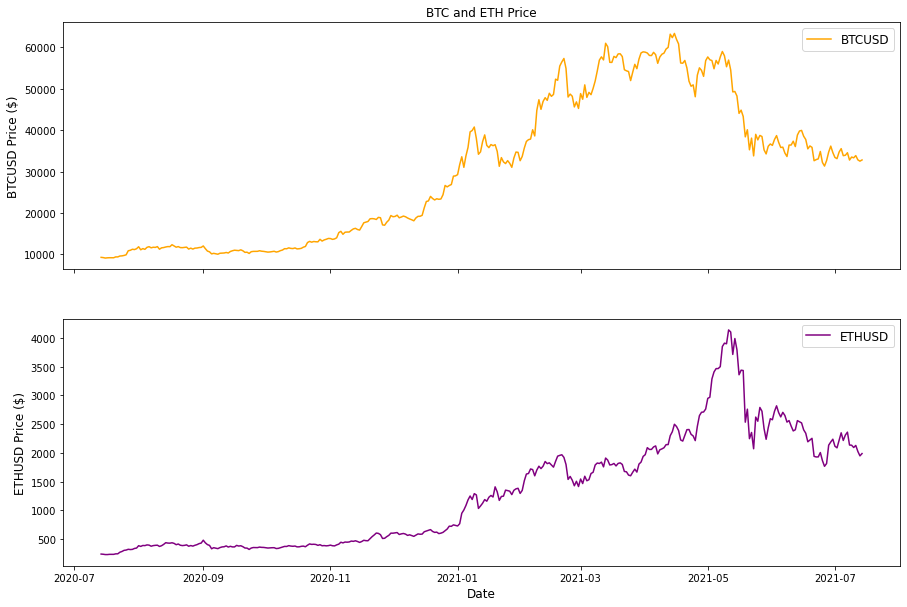

In [4]:
# Read data
df_btc = utils.read_bars("data/BTCUSD_daily_bars.csv")
df_eth = utils.read_bars("data/ETHUSD_daily_bars.csv")

# Plot close price
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
ax[0].plot(df_btc['Date'], df_btc['Close'], label="BTCUSD", color="orange")
ax[1].plot(df_eth['Date'], df_eth['Close'], label="ETHUSD", color="purple")
ax[0].legend(fontsize='large')
ax[1].legend(fontsize='large')
ax[1].set_xlabel("Date", fontsize='large')
ax[0].set_ylabel("BTCUSD Price ($)", fontsize='large')
ax[1].set_ylabel("ETHUSD Price ($)", fontsize='large')
ax[0].set_title("BTC and ETH Price", fontsize='large');

In [5]:
# Run backtests
result_btc = utils.run_backtest(df_btc, dma_crossover)
result_eth = utils.run_backtest(df_eth, dma_crossover)

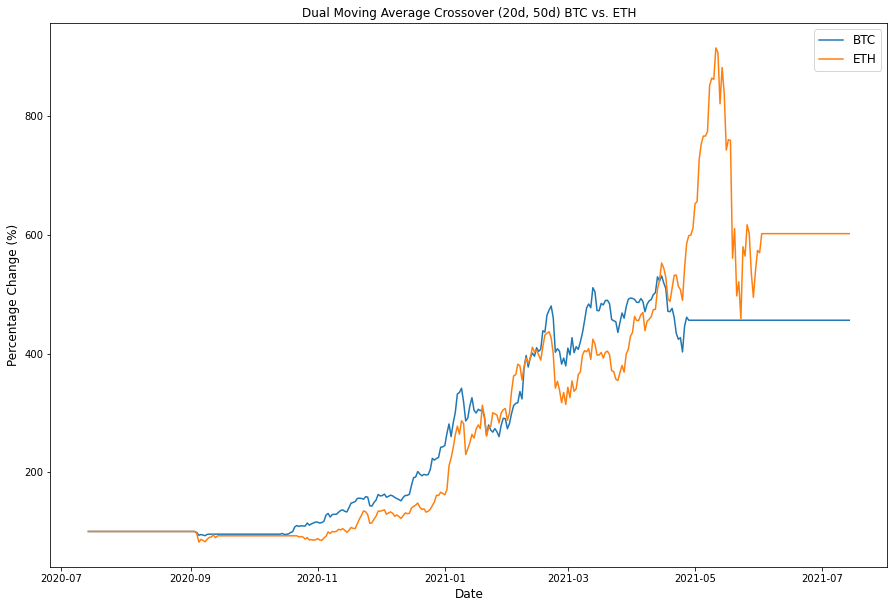

In [6]:
# Compute percent change
result_btc['Percent Change'] = result_btc['Portfolio Value'].apply(lambda x: 100 * x / result_btc['Portfolio Value'].iloc[0])
result_eth['Percent Change'] = result_eth['Portfolio Value'].apply(lambda x: 100 * x / result_eth['Portfolio Value'].iloc[0])

# Plot percent change
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(result_btc['Date'], result_btc['Percent Change'], label="BTC")
ax.plot(result_eth['Date'], result_eth['Percent Change'], label="ETH")
ax.legend(fontsize='large')
ax.set_xlabel("Date", fontsize='large')
ax.set_ylabel("Percentage Change (%)", fontsize='large')
ax.set_title("Dual Moving Average Crossover (20d, 50d) BTC vs. ETH", fontsize='large');